In [4]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from wrf import (getvar, ALL_TIMES)

In [5]:
# Load in LES test data
work_dir = "/data/keeling/a/sf20/b/WRF4_4/WRF/test/em_les/"
output_dir = "2022-11-14/132033/"
ncfile = Dataset(os.path.join(work_dir, output_dir, "wrfout_d01_2022-01-01_00:00:00"))

In [6]:
# Various parameters
t = getvar(ncfile, "Times", 
           #timeidx=1, 
           timeidx=ALL_TIMES
           )
p = getvar(ncfile, "pressure")
z = getvar(ncfile, "z")

In [7]:
p = getvar(ncfile, "pressure", timeidx=ALL_TIMES)

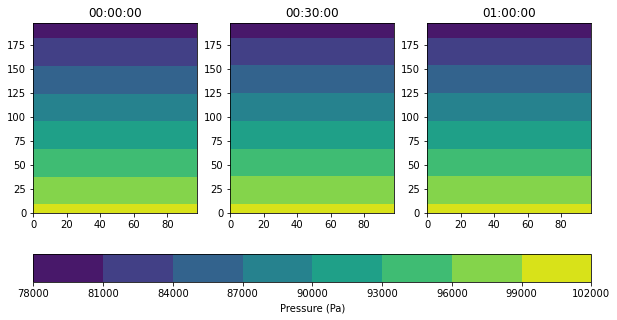

In [8]:
# Plot a cross section (y-z plane) of pressure
t = getvar(ncfile, "Times", 
           timeidx=ALL_TIMES, 
           )

t_idx = [0, int(len(t)/2), -1]
fig, ax = plt.subplots(1,3, figsize=(10, 5))
for tidx, sub_ax in zip(t_idx, ax):
    tstamp= pd.to_datetime(t.values[tidx]) 
    tstamp = tstamp.strftime('%H:%M:%S')
    press_cs = getvar(ncfile, "p", timeidx=tidx)
    p_cs = press_cs[:, :, 50]
    cf = sub_ax.contourf(p_cs)
    sub_ax.set_title(f'{tstamp}')

cbar = fig.colorbar(cf, ax=ax.ravel().tolist(), 
                    orientation='horizontal', label='Pressure (Pa)')


In [9]:
press_cs = getvar(ncfile, "p", timeidx=1)
press_cs.Time

<xarray.DataArray 'Time' ()>
array('2022-01-01T00:00:10.000000000', dtype='datetime64[ns]')
Coordinates:
    XTIME    float32 0.1667
    Time     datetime64[ns] 2022-01-01T00:00:10

Text(0, 0.5, 'Height (m)')

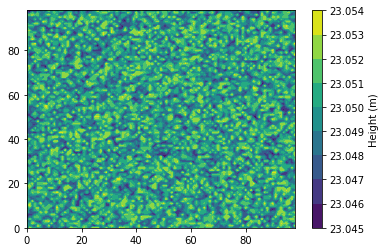

In [10]:
# Height variations in the third vertical layer (mean height 23 m)
fig, ax = plt.subplots(1,1)
cf = ax.contourf(z[2])
cbar = plt.colorbar(cf)
cbar.ax.set_ylabel('Height (m)')

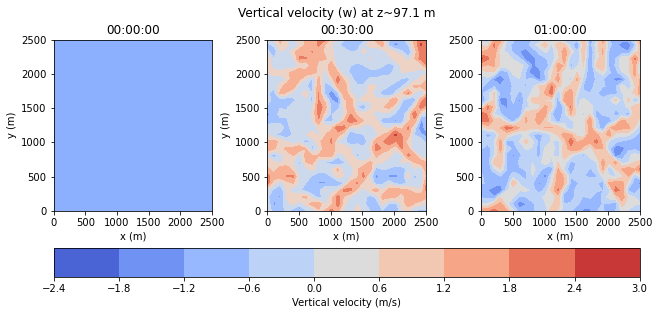

In [11]:
# Plot a cross section (x-y plane) of vertical velocity
import numpy as np

t = getvar(ncfile, "Times", 
           timeidx=ALL_TIMES, 
           )

# Get the mean height for a specified z index 
z = getvar(ncfile, "z", 
           timeidx=0, 
           )
z_idx = 10
z_mean = z[z_idx].values.mean()

dx, dy = 100, 100 # distance between consec. grid cell centers in meters
t_idx = [0, int(len(t)/2), -1]
fig, ax = plt.subplots(1,3, figsize=(10.5, 4.5))
for tidx, sub_ax in zip(t_idx, ax):
    # format the timestamp for displaying on figure
    tstamp= pd.to_datetime(t.values[tidx]) 
    tstamp = tstamp.strftime('%H:%M:%S')

    # Get vertical velocity for the specified timestamp
    w = getvar(ncfile, "W", timeidx=tidx)

    # Get a cross section (z-plane) of vertical velocity at specified height
    w_cs = w[z_idx, :, :] # z, y, x

    # scale the x and y axes from integer index values to distances in meters
    y_scaled = np.linspace(0, len(w_cs[0]), len(w_cs[0]))*dy
    x_scaled = np.linspace(0, len(w_cs[0]), len(w_cs[0]))*dx
    
    cf = sub_ax.contourf(x_scaled, y_scaled, w_cs, cmap='coolwarm')
    sub_ax.set_title(f'{tstamp}')
    sub_ax.set_ylabel('y (m)')
    sub_ax.set_xlabel('x (m)')
    sub_ax.set_xlim(0, 2500)
    sub_ax.set_ylim(0, 2500)

plt.subplots_adjust(wspace=.35)
plt.suptitle(f'Vertical velocity (w) at z~{z_mean:3.1f} m')
# set the colorbar so the range covers the extent shown on all subplots
cbar = fig.colorbar(cf, ax=ax.ravel().tolist(), 
                    orientation='horizontal', label='Vertical velocity (m/s)'
                    )


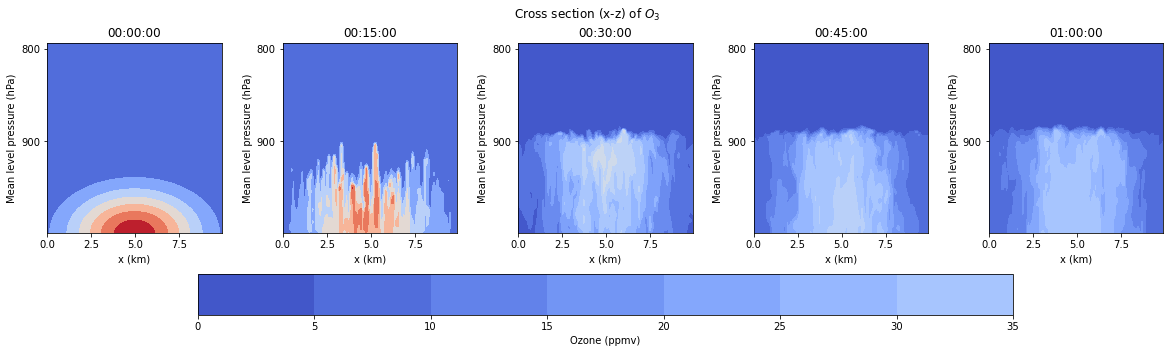

In [12]:
# Plot a cross section (x-z plane) of ozone
import numpy as np

t = getvar(ncfile, "Times", 
           timeidx=ALL_TIMES, 
           )

dx, dy = .1, .1 # distance between consec. grid cell centers in km

n_subplots = 5
fig, ax = plt.subplots(1, n_subplots, figsize=(n_subplots*4, 5))

t_idx = np.linspace(0, len(t)-1, n_subplots, dtype=int)

for tidx, sub_ax in zip(t_idx, ax):
    # format the timestamp for displaying on figure
    tstamp= pd.to_datetime(t.values[tidx]) 
    tstamp = tstamp.strftime('%H:%M:%S')

    # Get vertical velocity for the specified timestamp
    vardata = getvar(ncfile, "o3", timeidx=tidx)
    # Get a cross section of ozone in the middle of the domain (y index is 50)
    vardata_cs = vardata[:, 50, :] # z, y, x

    # create array of mean pressure values for each row (z) of the x-z plane pressure array 
    press = getvar(ncfile, "p", timeidx=0)
    press_cs = press[:, 50, :] # z, y, x
    mean_press = press_cs.mean(axis=1) / 100

    # scale the x axis from integer index values to distances in meters
    #z_scaled = np.linspace(0, len(vardata_cs[0]), len(vardata_cs[0]))*dy
    x_scaled = np.linspace(0, len(vardata_cs[0]), len(vardata_cs[0]))*dx

    cf = sub_ax.contourf(x_scaled, mean_press, vardata_cs, cmap='coolwarm', vmin=0, vmax=100)

    sub_ax.set_title(f'{tstamp}')
    sub_ax.set_ylabel('Mean level pressure (hPa)')
    sub_ax.set_xlabel('x (km)')
    sub_ax.invert_yaxis() # invert y-axis for pressure data
    #sub_ax.set_xlim(0, 2500)
    #sub_ax.set_ylim(0, 2500)
    sub_ax.locator_params(axis='both', nbins=4)
    #sub_ax.set_aspect('equal')

plt.subplots_adjust(wspace=.35)
plt.suptitle(f'Cross section (x-z) of $O_3$')
# set the colorbar so the range covers the extent shown on all subplots
cbar = fig.colorbar(cf, ax=ax.ravel().tolist(), 
                    orientation='horizontal', label='Ozone (ppmv)'
                    )


In [13]:
vardata_cs.max().values / 100

0.34785400390625

In [14]:
def plot_o3_crosssec(tidx):
    # Plot a cross section (x-z plane) of ozone
    import numpy as np

    dx, dy = .1, .1 # distance between consec. grid cell centers in km
    fig, ax = plt.subplots(1,1, figsize=(5, 5))

    # format the timestamp for displaying on figure
    tstamp= pd.to_datetime(t.values[tidx]) 
    tstamp = tstamp.strftime('%H:%M:%S')

    # Get vertical velocity for the specified timestamp
    vardata = getvar(ncfile, "o3", timeidx=tidx)

    # Get a cross section of ozone in the middle of the domain (x index 100)
    vardata_cs = vardata[:, :, 50] # z, y, x

    press = getvar(ncfile, "p", timeidx=0)
    press_cs = press[:, :, 50] # z, y, x
    mean_press = press_cs.mean(axis=1) / 100

    # scale the x and y axes from integer index values to distances in meters
    #z_scaled = np.linspace(0, len(vardata_cs[0]), len(vardata_cs[0]))*dy
    y_scaled = np.linspace(0, len(vardata_cs[0]), len(vardata_cs[0]))*dx

    cf = ax.contourf(y_scaled, mean_press, vardata_cs, cmap='coolwarm')
    ax.set_title(f'{tstamp}')
    ax.set_ylabel('pressure')
    ax.set_xlabel('y (km)')
    ax.invert_yaxis()
    #ax.set_xlim(0, 2500)
    #ax.set_ylim(0, 2500)
    ax.locator_params(axis='both', nbins=4)
    #ax.set_aspect('equal')

    #plt.subplots_adjust(wspace=.35)
    plt.suptitle(f'Cross section (y-z) of $O_3$')
    # set the colorbar so the range covers the extent shown on all subplots
    cbar = fig.colorbar(cf, #ax=ax.ravel().tolist(), 
                        orientation='horizontal', label='Ozone (ppmv)'
                        )
    return


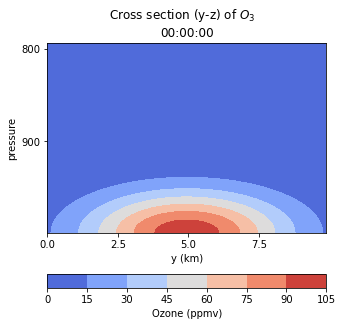

In [15]:
plot_o3_crosssec(tidx=0)

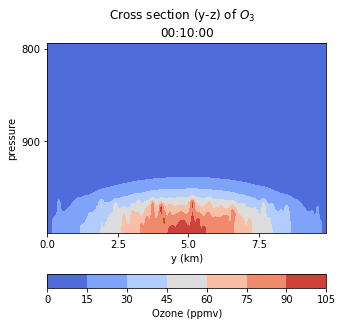

In [16]:
plot_o3_crosssec(tidx=60)

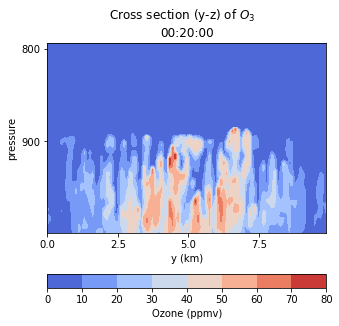

In [17]:
plot_o3_crosssec(tidx=120)

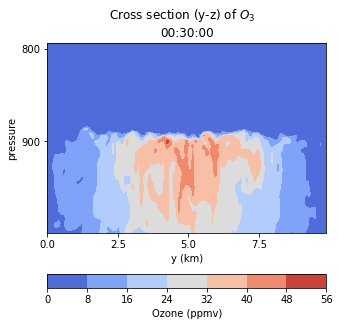

In [18]:
plot_o3_crosssec(tidx=180)

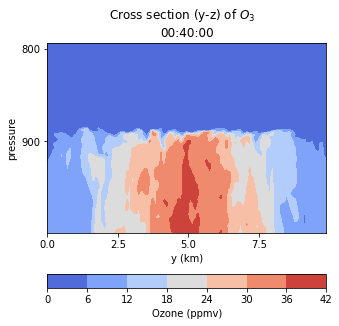

In [19]:
plot_o3_crosssec(tidx=240)

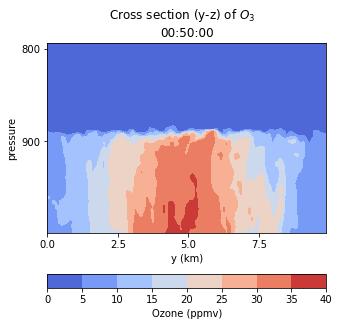

In [20]:
plot_o3_crosssec(tidx=300)

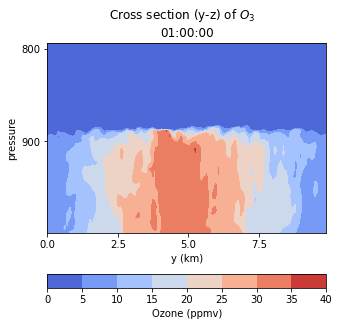

In [21]:
plot_o3_crosssec(tidx=360)